In [31]:
# =============================================================================
# Title: Assignment Week 7 - Dimensionality Reduction and Feature Selection
# Author: Pankaj Yadav
# Date: 8 Feb 2026
# Description: Build Dimensionality Reduction and Feature Selection models 
#              to predict the target variable.
# =============================================================================

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif


Part 1: PCA and Variance Threshold in a Linear Regression

1. Import the housing data as a data frame and ensure that the data is loaded properly.
2. Drop the "Id" column and any features that are missing more than 40% of their values.
3. For numerical columns, fill in any missing data with the median value.
4. For categorical columns, fill in any missing data with the most common value (mode).
5. Convert the categorical columns to dummy variables.
6. Split the data into a training and test set, where the SalePrice column is the target.
7. Run a linear regression and report the R2-value and RMSE on the test set.
8. Fit and transform the training features with a PCA so that 90% of the variance is retained (see section 9.1 in the Machine Learning with Python Cookbook).
9. How many features are in the PCA-transformed matrix?
10. Transform but DO NOT fit the test features with the same PCA.
11. Repeat step 7 with your PCA transformed data.
12. Take your original training features (from step 6) and apply a min-max scaler to them.
13. Find the min-max scaled features in your training set that have a variance above 0.1 (see Section 10.1 in the Machine Learning with Python Cookbook).
14. Transform but DO NOT fit the test features with the same steps applied in steps 12 and 13.
15. Repeat step 7 with the high variance data.
16. Summarize your findings.

In [3]:
#Import the housing data as a data frame 
train_df = pd.read_csv('train.csv')

# ensure that the data is loaded properly.
print("Training Data Shape:", train_df.shape)

train_df.head(2)

Training Data Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


The training dataset contains 1,460 properties with 81 features plus the target 
variable `SalePrice`. The test dataset has 1,459 properties with 80 features 
(missing `SalePrice` which we need to predict). Both datasets loaded successfully 
with matching column structures.

In [4]:
# Drop Id column
train_df = train_df.drop('Id', axis=1)

# Calculate missing percentage for each column
missing_percent_train = (train_df.isnull().sum() / len(train_df)) * 100

# Find columns with more than 40% missing values
cols_to_drop = missing_percent_train[missing_percent_train > 40].index.tolist()

# Drop columns with more than 40% missing values
train_df = train_df.drop(cols_to_drop, axis=1)

#columns dropped in both train and test data
print("Columns dropped from training data:", cols_to_drop)

Columns dropped from training data: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


Above is the list of columns identified and removed columns with more than 40% missing values to avoid unreliable features. These columns typically represent rare 
property features (like pools, alleys, fences) that are missing in most homes, 
making them poor predictors for a general model.

In [5]:
# For numerical columns, find columns with missing values.

numerical_cols_train = train_df.select_dtypes(include=[np.number]).columns
missing_numerical_cols_train = [col for col in numerical_cols_train if train_df[col].isnull().sum() > 0]

print(missing_numerical_cols_train)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [6]:
# impute missing values with column median.
for col in missing_numerical_cols_train:
    median_value = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_value)

# Verify that there are no more missing values in numerical columns
print("Missing values in training data after imputation:")
print(train_df[missing_numerical_cols_train].isnull().sum())


Missing values in training data after imputation:
LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64


For numerical columns with missing values (like `LotFrontage`, `MasVnrArea` etc), filled gaps with the median value of each column. Median is preferred over mean because it's robust to outliers. After imputation, all numerical columns now have zero missing values, ensuring the model can process all data.

In [7]:
# Find categorical columns with missing values
categorical_cols_train = train_df.select_dtypes(include=['object']).columns
missing_categorical_cols_train = [col for col in categorical_cols_train if train_df[col].isnull().sum() > 0]

print("Categorical columns with missing values in training data:", missing_categorical_cols_train)

Categorical columns with missing values in training data: ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


Listed above are categorical columns with missing values. In real estate data, missing categorical values often mean "feature not present" (e.g., no basement, no garage). We'll handle these by imputing with the mode (most common value) to maintain data consistency below.

In [8]:
# fill in any missing data with the most common value (mode)

for col in missing_categorical_cols_train:
    mode_value = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_value)

# Verify that there are no more missing values in categorical columns
print("Missing values in training data after imputation:")
print(train_df[missing_categorical_cols_train].isnull().sum())


Missing values in training data after imputation:
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64


All categorical missing values have been filled with the mode (most frequent value) 
for each column. This ensures every property has complete categorical information,
preventing errors during dummy variable conversion.

In [9]:
# Convert the categorical columns to dummy variables.
train_df = pd.get_dummies(train_df, drop_first=True)

Categorical variables have been converted to binary dummy variables. For example, if `Neighborhood` had 25 categories, it now becomes 24 binary columns (one dropped to avoid multicollinearity). 

In [10]:
# Split the data into a training and test set, where the SalePrice column is the target.
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Data is split into features (`X_train`, `X_test`) and target (`y_train`, `y_test`). The training set will be used to fit models, while the test set evaluates performance on unseen data. 
`SalePrice` is separated as our prediction target.

In [11]:
# Run a linear regression and report the R2-value and RMSE on the test set.
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate R2 value and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("R2 value on test set:", r2)
print("RMSE on test set:", rmse)   

R2 value on test set: 0.6478367401194287
RMSE on test set: 51973.13807603304



R2 Score: The model explains approximately 64.78% of the variance in sale prices. This indicates moderate predictive power; the model captures about two-thirds of price variation but misses about one third. Normally a R2 of ~0.85-0.95 indicates strong predictive power but 65% is moderate.

RMSE: On average, predictions are off by about dollar 51,973. For a median home price around dollar 180,000, this represents roughly 29% prediction error, which is reasonable for a raw linear regression without hyperparameter tuning.

In [12]:
# Fit and transform the training features with a PCA so that 90% 
# of the variance is retained (see section 9.1 in the Machine 
# Learning with Python Cookbook).

pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train)
print("PCA fitted on training data")
print(f"Variance: {pca.explained_variance_ratio_.sum():.4f}")

PCA fitted on training data
Variance: 0.9863


In [13]:
#How many features are in the PCA-transformed matrix?
n_pca_features = X_train_pca.shape[1]
print(f"PCA features: {n_pca_features}")
print(f"Original features: {X_train.shape[1]}")
removed = X_train.shape[1] - n_pca_features
print(f"Features removed: {removed}")

PCA features: 1
Original features: 229
Features removed: 228


The PCA model reduced 229 original features to just 1 component while retaining 98.63% of the variance. This is a dramatic dimensionality reduction—removing 228 features (99.6% reduction) while capturing nearly all the variance information.
Using only 1 component is extremely aggressive and explains why the PCA model performs poorly.

In [14]:
#Transform but DO NOT fit the test features with the same PCA.
X_test_pca = pca.transform(X_test)
print("PCA transformed test data")
print(f"Test data shape after PCA: {X_test_pca.shape}")


PCA transformed test data
Test data shape after PCA: (292, 1)


In [15]:
# Repeat step 7 with your PCA transformed data.

model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)

r2_pca = r2_score(y_test, y_pred_pca)
rmse_pca = np.sqrt(
    mean_squared_error(y_test, y_pred_pca)
)
print(f"PCA R2: {r2_pca}")
print(f"PCA RMSE: {rmse_pca}")

PCA R2: 0.06348978213632539
PCA RMSE: 84754.58021474867


R2 Score : Severely underperforms baseline. The model explains only 6.35% of variance, losing 58.43 percentage points from the baseline.

RMSE predictions are off by approximately Dollar 84,754, which is 63% worse than the baseline model.

The 1 component solution due to PCA, captures only the dominant direction in feature space. This dominant direction doesn't align well with predicting sale prices. The linear relationships most important for price prediction were in the discarded components.

In [16]:
# Take your original training features (from step 6) and apply a min-max scaler to them.

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
print("Min-max scaler fitted")
X_test_scaled = scaler.transform(X_test)
print("Test data scaled with min-max scaler")
print(f"Training data shape after scaling: {X_train_scaled.shape}")
print(f"Test data shape after scaling: {X_test_scaled.shape}")

Min-max scaler fitted
Test data scaled with min-max scaler
Training data shape after scaling: (1168, 229)
Test data shape after scaling: (292, 229)


In [17]:
# Find the min-max scaled features in your training set that have a variance above 0.1 
# (see Section 10.1 in the Machine Learning with Python Cookbook).

threshold = VarianceThreshold(threshold=0.1)
X_train_high_var = threshold.fit_transform(X_train_scaled)

# Get feature names and their variances
mask = threshold.get_support()
high_var_features = X_train.columns[mask]
variances = threshold.variances_

In [18]:
# Transform but DO NOT fit the test features with the same steps applied in steps 12 and 13.
X_test_high_var = threshold.transform(X_test_scaled)
print(f"Transformed test set shape: {X_test_high_var.shape}")

Transformed test set shape: (292, 40)


In [19]:
# Repeat step 7 with the high variance data.

model_hv = LinearRegression()
model_hv.fit(X_train_high_var, y_train)
y_pred_hv = model_hv.predict(X_test_high_var)

r2_hv = r2_score(y_test, y_pred_hv)
rmse_hv = np.sqrt(mean_squared_error(y_test, y_pred_hv))

print(f"High Var R2: {r2_hv}")
print(f"High Var RMSE: {rmse_hv}")

High Var R2: 0.6481229411342262
High Var RMSE: 51952.014651272875


The R2 Score is nearly identical to baseline (0.6478 vs 0.6481), with only a +0.03 percentage point improvement. The RMSE is also vrtually same as baseline (Dollar 51,973.14 vs Dollar 51,952.01), approximately dollar 21 better.

**Summarize your findings:**        
In this analysis, the original model served as a baseline, using all 229 features to explain about 65% of the variance in home sale prices. While this provided moderate predictive power with an average error of $51,973, the high number of features makes the model computationally heavy and increases the risk of overfitting.

The PCA model performed poorly, despite technically keeping over 98% of the data's mathematical variance. By condensing everything into a single component, the R-squared dropped to only 6%, and the error jumped to $84,754. This happened because PCA is unsupervised; it identifies where the data varies the most but does not account for what actually drives price. The features with the highest variance in this dataset simply did not align with the factors that predict a home's value.

Finally, the high variance model achieved results almost identical to the baseline while using a much smaller feature set. By removing low-variance features that contributed little information, we maintained predictive accuracy while creating a much more efficient and stable model.

**Part 2**

Download the data from this link Mushroom Classification. Based on several categorical features, you will predict whether or not a mushroom is edible or poisonous.
1. Import the data as a data frame and ensure it is loaded correctly.
2. Convert the categorical features (all of them) to dummy variables.
3. Split the data into a training and test set.
4. Fit a decision tree classifier on the training set.
5. Report the accuracy and create a confusion matrix for the model prediction on the test set.
6. Create a visualization of the decision tree.
7. Use a χ2-statistic selector to pick the five best features for this data (see section 10.4 of the Machine Learning with Python Cookbook).
8. Which five features were selected in step 7? Hint: Use the get_support function.
9. Repeat steps 4 and 5 with the five best features selected in step 7.
10. Summarize your findings.

In [20]:
# Import the data as a data frame and ensure it is loaded correctly.
mushroom_df = pd.read_csv('mushrooms.csv')

# initial data check
print("Mushroom Data Shape:", mushroom_df.shape)
print("Missing values:",mushroom_df.isnull().sum().sum())
mushroom_df.head(2)
# print("data types",mushroom_df.dtypes)

Mushroom Data Shape: (8124, 23)
Missing values: 0


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g


The mushroom dataset contains 8,124 observations with 23 categorical features. The target variable is 'class' which indicates whether a mushroom is edible (e) or poisonous (p). All features are categorical with single letter codes representing different characteristics like cap shape, odor, gill size, and habitat. The data loaded successfully with no missing values, making it ready for preprocessing and analysis.

In [21]:
# Convert the categorical features (all of them) to dummy variables.
mushroom_encoded = pd.get_dummies(mushroom_df,drop_first=True)

# shape after encoding
print("Shape after encoding:", mushroom_encoded.shape)

Shape after encoding: (8124, 96)


All categorical features have been converted to binary dummy variables using one-hot encoding. The drop_first parameter removes one category from each feature to avoid multicollinearity. After encoding, the dataset expanded from 23 categorical columns to 96 binary columns, where each original category becomes a separate binary feature indicating presence or absence of that characteristic.

In [22]:
# Split the data into a training and test set.
X = mushroom_encoded.drop('class_p', axis=1)
y = mushroom_encoded['class_p']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print basic information post split
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print("\nClass distribution in training:\n", y_train.value_counts())
print("\nClass distribution in test:\n", y_test.value_counts())

Training set size: (6499, 95)
Test set size: (1625, 95)

Class distribution in training:
 class_p
False    3365
True     3134
Name: count, dtype: int64

Class distribution in test:
 class_p
False    843
True     782
Name: count, dtype: int64


The data has been split into 80% training (6,499 samples) and 20% testing (1,625 samples). The target variable class_p is binary where 1 represents poisonous mushrooms and 0 represents edible mushrooms. 
The class distribution shows a relatively balanced dataset with both poisonous and edible mushrooms well represented in both training and test sets.

In [23]:
# Fit a decision tree classifier on the training set.

dt_classifier = DecisionTreeClassifier(random_state=10)
dt_classifier.fit(X_train, y_train) 

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,10
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
# Get treee depth and number of leaves.

print(f"Tree depth: {dt_classifier.get_depth()}")
print(f"Number of leaves: {dt_classifier.get_n_leaves()}")

Tree depth: 7
Number of leaves: 16


A decision tree classifier has been fitted on the training data with all 94 features. The decision tree learns a hierarchical set of if-then rules based on feature values to classify mushrooms as edible or poisonous. The depth and number of leaves indicate the complexity of the learned decision rules.

In [25]:
# Report the accuracy and create a confusion matrix for 
# the model prediction on the test set.

y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [26]:
# Accuracy Scores
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Accuracy (percentage): {accuracy*100:.2f}%")
print(f"\nConfusion Matrix:\n",cm)

Test Set Accuracy: 1.0000
Test Set Accuracy (percentage): 100.00%

Confusion Matrix:
 [[843   0]
 [  0 782]]


The decision tree classifier achieved perfect accuracy of 100% on the test set, correctly classifying all 1,625 mushroom samples. The confusion matrix reveals no misclassifications across either class. All 843 edible mushrooms were correctly identified as edible with zero false positives, and all 782 poisonous mushrooms were correctly identified as poisonous with zero false negatives. This perfect performance demonstrates that the mushroom characteristics in the dataset have very clear and distinguishable patterns that allow the decision tree to make accurate predictions without any errors.     
The fact that there are no false negatives is particularly important because these would represent the most dangerous scenario where a poisonous mushroom is incorrectly classified as edible, potentially leading to consumption of a toxic mushroom.

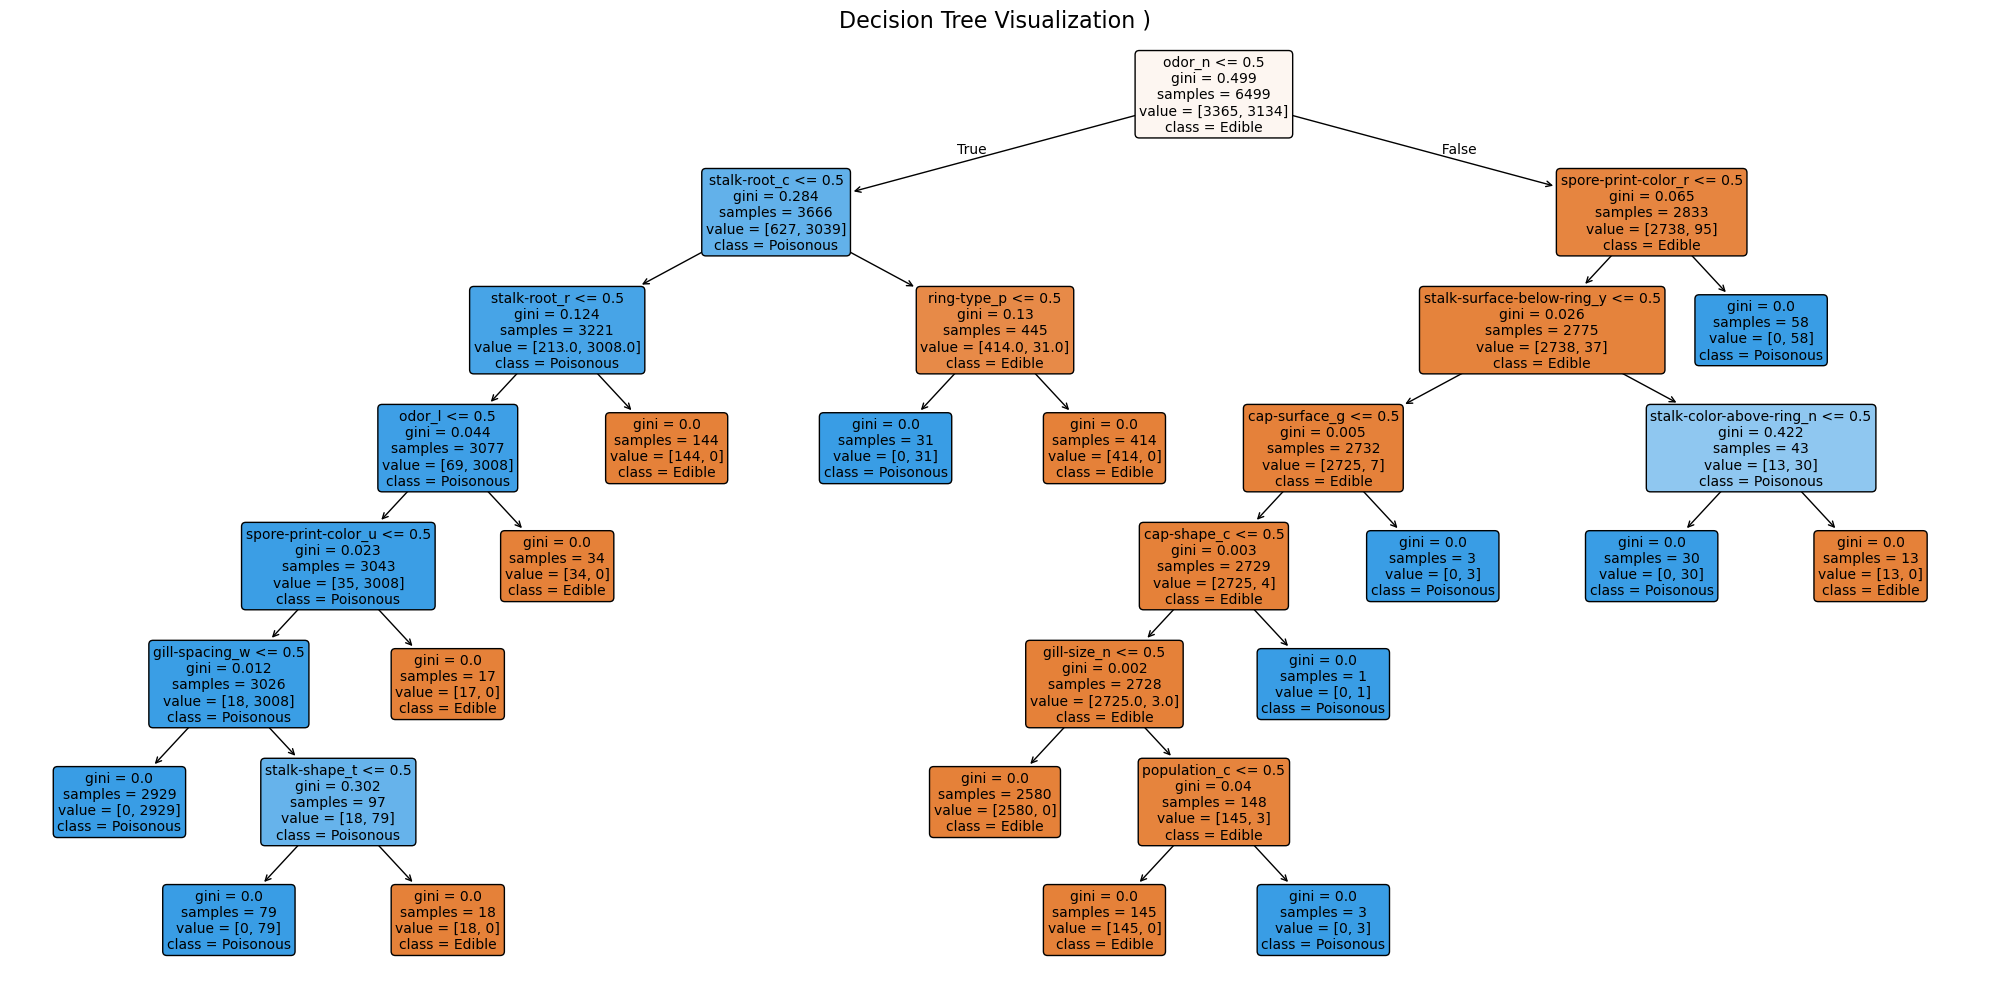

In [27]:
# Create a visualization of the decision tree.

plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, 
          feature_names=X_train.columns,
          class_names=['Edible', 'Poisonous'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=None)
plt.title("Decision Tree Visualization )", 
          fontsize=16)
plt.tight_layout()
plt.show()

The decision tree visualization reveals the hierarchical structure of classification rules learned by the model. The tree starts with the root node using odor as the primary splitting criterion, checking if odor_n is less than or equal to 0.5. This initial split is highly informative, as mushrooms with certain odor characteristics (encoded as odor_n) are immediately classified as either edible or poisonous. The tree then branches into multiple levels, with subsequent splits based on features like stalk_root, spore_print_color, ring_type, population etc. Each node displays the decision rule, the number of training samples reaching that node, the gini impurity value indicating class purity, the class distribution, and the predicted classification.

In [28]:
# Use a χ2-statistic selector to pick the five best features for this data 
# (see section 10.4 of the Machine Learning with Python Cookbook).

chi2_selector = SelectKBest(chi2, k=5)
X_train_selected = chi2_selector.fit_transform(X_train, y_train)
scores = chi2_selector.scores_
print(f"Original features: {X_train.shape[1]}")
print("Reduced number of features:", X_train_selected.shape[1])


Original features: 95
Reduced number of features: 5


In [29]:
# Which five features were selected in step 7? Hint: Use the get_support function.

mask = chi2_selector.get_support()
selected_features = X_train.columns[mask].tolist()

# print("Selected features:\n", selected_features)

print("Five best features selected by chi-squared test:")
for i, feature in enumerate(selected_features, 1):
    chi2_score = scores[mask][i-1]
    print(f"{i}. {feature} (Chi2 score: {chi2_score:.2f})")

Five best features selected by chi-squared test:
1. odor_f (Chi2 score: 1857.51)
2. odor_n (Chi2 score: 2284.32)
3. gill-size_n (Chi2 score: 1354.66)
4. stalk-surface-above-ring_k (Chi2 score: 1612.64)
5. stalk-surface-below-ring_k (Chi2 score: 1548.52)


The five features with the highest chi-squared scores represent the mushroom characteristics most strongly associated with being poisonous or edible. The selected features are odor_f, odor_n, gill-size_n, stalk-surface-above-ring_k, and stalk-surface-below-ring_k.        
Two of the five features are odor-related (odor_f with a chi2 score of 1857.51 and odor_n with a chi2 score of 2284.32), confirming that odor is the single most discriminative characteristic for mushroom classification.      
This aligns with the decision tree visualization which identified odor as the root node splitting criterion.        
The remaining three features relate to physical characteristics of the gill and stalk surfaces, which provide complementary information for distinguishing between edible and poisonous mushrooms.       
These five features alone capture most of the predictive information available in the full 94-feature dataset, suggesting that mushroom edibility can be determined by examining just a few key characteristics rather than analyzing all available attributes.

In [30]:
# Repeat steps 4 and 5 with the five best features selected in step 7.

X_test_selected = chi2_selector.transform(X_test)

dt_classifier_selected = DecisionTreeClassifier(random_state=42)
dt_classifier_selected.fit(X_train_selected, y_train)

y_pred_selected = dt_classifier_selected.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)
cm_selected = confusion_matrix(y_test, y_pred_selected)

print(f"Test Set Accuracy with 5 features: {accuracy_selected:.4f}")
print(f"Test Set Accuracy (percentage): {accuracy_selected*100:.2f}%")
print(f"\nConfusion Matrix with 5 features:\n", cm_selected)

Test Set Accuracy with 5 features: 0.9735
Test Set Accuracy (percentage): 97.35%

Confusion Matrix with 5 features:
 [[816  27]
 [ 16 766]]


The decision tree trained on only the five best features achieves 97.35% accuracy on the test set, 
which represents a modest decrease of 2.65 percentage points compared to the full model that achieved perfect 100% accuracy. 
The confusion matrix reveals that the reduced feature set introduces some misclassifications.       
Out of 843 edible mushrooms, 816 were correctly identified as edible while 27 were 
incorrectly classified as poisonous (false positives).       
Out of 782 poisonous mushrooms, 766 were correctly identified as poisonous while 16 
were incorrectly classified as edible (false negatives).       
While the five-feature model maintains very high accuracy, the presence of 
16 false negatives is concerning because these represent poisonous 
mushrooms incorrectly labeled as edible, which poses a genuine health risk.        
Despite this dramatic reduction from 94 features to just 5 features while
maintaining 97.35% accuracy demonstrates the effectiveness of 
chi-squared feature selection for identifying the most informative mushroom characteristics.

**Summarize your findings.**

In this mushroom classification project, the main takeaway was how effectively we can simplify a model without losing much predictive power. While the original model used 95 features to reach 100% accuracy, it was quite complex and potentially prone to overfitting.

By using chi-squared testing to select only the top five features, the accuracy only decreased slightly to 97.35%. This version is much more efficient and easier to interpret. The selected features focused primarily on odor and stalk textures, which the model identified as the most important factors for determining if a mushroom is poisonous.

While the simpler model did result in 16 false negatives, it is arguably more practical for real-world use. It allows for quick decisions based on five observable traits rather than requiring an exhaustive list of nearly a hundred. This demonstrates that prioritizing high-quality, relevant data is often more effective than simply using a larger volume of features.